This following A Karpathy's "The spelled-out intro to neural networks and backpropagation: building micrograd" from YouTube: https://www.youtube.com/watch?v=VMj-3S1tku0

In [625]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [626]:
h=0.0001

a=2.0
b=-3.0
c=10.0

d1=a*b+c
c+=h
d2=a*b+c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [627]:
class Value:
    def __init__(self,data,_children=(),_op='',label='') -> None:
        self.data=data
        self.grad=0 
        self._backward=lambda: None
        self._prev=set(_children)
        self._op=_op
        self.label=label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data+other.data,(self,other),'+')

        def _backward():
            self.grad+=1.0*out.grad
            other.grad+=1.0*out.grad
        out._backward=_backward
        
        return out
    
    def __mul__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data*other.data,(self,other),'*')

        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
        out._backward=_backward

        return out
    
    def __rmul__(self,other):
        return self*other

    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only supporting int/float powers"
        out=Value(self.data**other,(self,),f'**{other}')

        def _backward():
            self.grad+=other*(self.data**(other-1))*out.grad
        out._backward=_backward

        return out

    def __truediv__(self,other):
        return self*other**-1

    def __neg__(self):
        return self*-1

    def __sub__(self,other):
        return self+(-other)

    # we will use tanh as the activation function
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,(self,),'tanh')

        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward

        return out

    def exp(self):
        x=self.data
        out=Value(math.exp(x),(self,),'exp')

        def _backward():
            self.grad+=out.data*out.grad
        out._backward=_backward

        return out

    def backward(self):

        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad=1.0
        for node in reversed(topo):
            node._backward()

# a=Value(2.0,label='a')
# b=Value(-3.0,label='b')
# c=Value(10.0,label='c')
# e=a*b; e.label='e'
# d=e+c; d.label='d'
# f=Value(-2.0,label='f')
# L=d*f; L.label='L'
# L


In [628]:
a=Value(2.0)
b=Value(4.0)

a/b

# a*(1/b)
# a*(b**-1)

Value(data=0.5)

In [629]:
from graphviz import Digraph

def trace(root):
    nodes, edges=set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot=Digraph(format='svg',graph_attr={'rankdir': 'LR'}) #LR = left to Right

    nodes,edges=trace(root)
    for n in nodes:
        uid=str(id(n))
        # create a rectangular 'record' node
        dot.node(name=uid,label="{%s | data %.2f | grad %.4f}" % (n.label,n.data,n.grad),shape='record')
        if n._op:
            # create an op node
            dot.node(name=uid + n._op,label=n._op)
            # connect node to it
            dot.edge(uid+n._op,uid)
    
    for n1,n2 in edges:
        # connect n1 to op node n2
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
    
    return dot


In [630]:
# draw_dot(L)

In [631]:
# c.grad=-2.0
# e.grad=-2.0

In [632]:
# def lol():
    
#     h=0.001
    
#     a=Value(2.0,label='a')
#     b=Value(-3.0,label='b')
#     c=Value(10.0,label='c')
#     e=a*b; e.label='e'
#     d=e+c; d.label='d'
#     f=Value(-2.0,label='f')
#     L=d*f; L.label='L'
#     L1=L.data

#     a=Value(2.0,label='a')
#     b=Value(-3.0,label='b')
#     c=Value(10.0,label='c')
#     c.data+=h
#     e=a*b; e.label='e'
#     d=e+c; d.label='d'
#     f=Value(-2.0,label='f')
#     L=d*f; L.label='L'
#     L2=L.data

#     print((L2-L1)/h)

# lol()

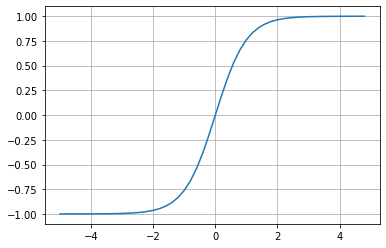

In [633]:
# tanh will be used as the activation function
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)));plt.grid();

In [634]:
# inputs 
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')
# weights
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')
# bias
b=Value(6.881373587,label='b')
# n, the raw output at neuron x1w1+x2w2+b, before 
# passing it throught the activation function
x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1w1+x2w2'
n=x1w1x2w2+b; n.label='n'
# pass n through activation function tanh
o=n.tanh(); 
o.label='o'
o.backward()

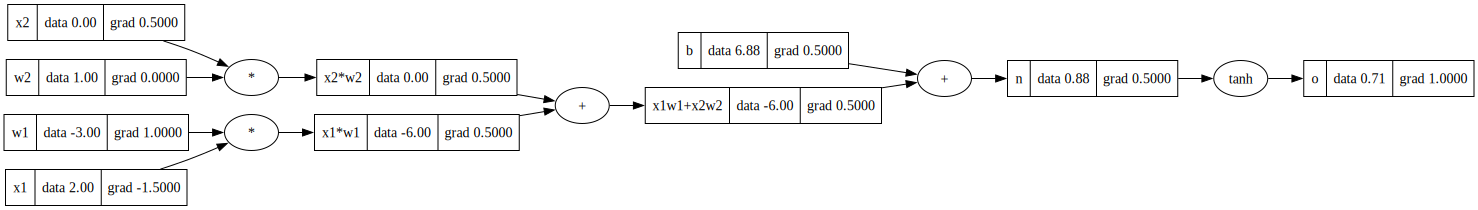

In [635]:
draw_dot(o)

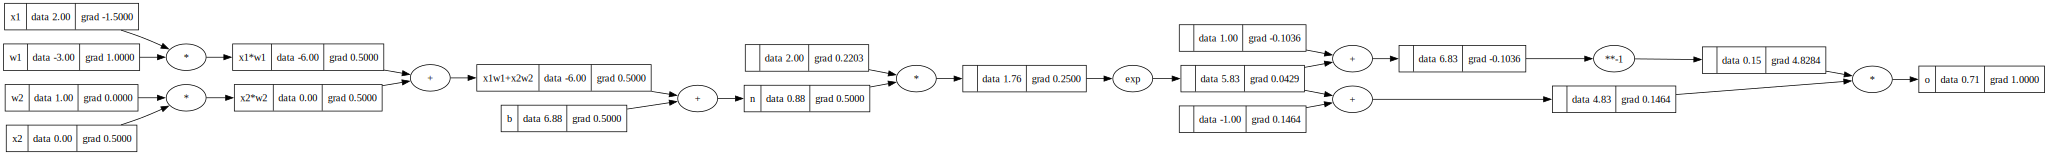

In [636]:
# inputs 
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')
# weights
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')
# bias
b=Value(6.881373587,label='b')
# n, the raw output at neuron x1w1+x2w2+b, before 
# passing it throught the activation function
x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1w1+x2w2'
n=x1w1x2w2+b; n.label='n'
# pass n through activation function tanh ... expanded form
e=(2*n).exp()
o=((e-1))/(e+1)

# ---
o.label='o'
o.backward()
draw_dot(o)

In [637]:
# o.backward()

In [638]:
o.grad=1.0

topo=[]
visited=set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

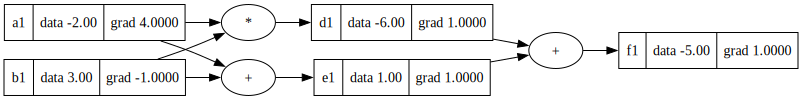

In [639]:
a1=Value(-2.0, label='a1')
b1=Value(3.0,label='b1')
d1=a1*b1; d1.label='d1'
e1=a1+b1; e1.label='e1'
f1=d1+e1; f1.label='f1'

f1.backward()

draw_dot(f1)

In [643]:
import torch
import random

In [646]:
class Neuron:
    def __init__(self,nin):
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b=Value(random.uniform(-1,1))

    def __call__(self,x):
        # for w*x + b
        return 0.0
    
x=[2.0,3.0]
n=Neuron(2)
n(x)

0.0